In [61]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import xgboost as xgb


In [4]:
filename = 'car_fuel_efficiency.csv'

raw_data = pd.read_csv(filename)

In [5]:
raw_data.describe(include='all')

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
count,9704.000000,9222.000000,8996.000000,9704.000000,8774.000000,9704.000000,9704,9704,9704,9202.000000,9704.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,Europe,Gasoline,All-wheel drive,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3254,4898,4876,NaN,NaN
mean,199.708368,3.962481,149.657292,3001.280993,15.021928,2011.484027,NaN,NaN,NaN,-0.006412,14.985243
std,49.455319,1.999323,29.879555,497.894860,2.510339,6.659808,NaN,NaN,NaN,1.048162,2.556468
min,10.000000,0.000000,37.000000,952.681761,6.000000,2000.000000,NaN,NaN,NaN,-4.000000,6.200971
25%,170.000000,3.000000,130.000000,2666.248985,13.300000,2006.000000,NaN,NaN,NaN,-1.000000,13.267459
50%,200.000000,4.000000,149.000000,2993.226296,15.000000,2012.000000,NaN,NaN,NaN,0.000000,15.006037
75%,230.000000,5.000000,170.000000,3334.957039,16.700000,2017.000000,NaN,NaN,NaN,1.000000,16.707965


In [6]:
raw_data.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [7]:
raw_data = raw_data.fillna(0)

In [8]:
X_train, X_test_val, y_train, y_test_val = train_test_split(raw_data.drop('fuel_efficiency_mpg', axis=1), 
                                                    raw_data['fuel_efficiency_mpg'], 
                                                    test_size=0.4, 
                                                    random_state=1)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_test_val,
                                                y_test_val,
                                                test_size=0.5,
                                                random_state=1)



In [10]:
print(f'Raw data - {raw_data.shape[0]}\nX_train -  {X_train.shape[0]}\nX_val -  {X_val.shape[0]}\nX_test -  {X_test.shape[0]}')

Raw data - 9704
X_train -  5822
X_val -  1941
X_test -  1941


In [11]:
dv = DictVectorizer(sparse=True)

X_train_dict = X_train.to_dict('records')
X_val_dict = X_val.to_dict('records')

# dv transform
X_train_dv = dv.fit_transform(X_train_dict)
X_val_dv = dv.fit_transform(X_val_dict)


#### DT Regressor

In [12]:
tree_clf = DecisionTreeRegressor(max_depth=1)
tree_clf.fit(X_train_dv, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [13]:
export_graphviz(
    tree_clf,
    out_file='fe_tree.dot',
    feature_names=dv.get_feature_names_out(),
    rounded=True,
    filled=True,
)

#### RF Regressor

In [14]:
rf_reg = RandomForestRegressor(n_estimators=10,
                               random_state=1,
                               n_jobs=-1
                              )

rf_reg.fit(X_train_dv, y_train)

y_pred_rf = rf_reg.predict(X_val_dv)


In [20]:
# RMSE on validation
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f'Validation RMSE: {rmse_val:.4f}')

Validation RMSE: 0.4603


In [40]:
eval_values = []

for n_estimator in range(10,201,10):
    rf_reg = RandomForestRegressor(n_estimators=n_estimator,
                               random_state=1,
                               n_jobs=-1
                              )

    rf_reg.fit(X_train_dv, y_train)
    
    y_pred_rf = rf_reg.predict(X_val_dv)

    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf))

    eval_values.append({'n_estimator':n_estimator,'rmse':rmse_val})
    

In [41]:
eval_df = pd.DataFrame(eval_values)
eval_df.plot(x='n_estimator', y='rmse')


<Axes: xlabel='n_estimator'>

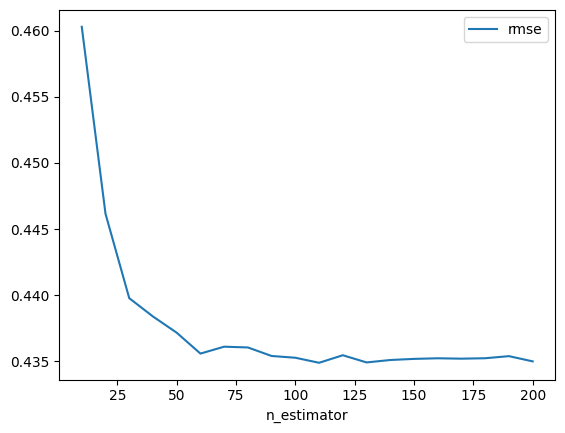

In [44]:
eval_df

,n_estimator,rmse
0,10,0.460282
1,20,0.446157
2,30,0.439778
3,40,0.438394
4,50,0.437170
5,60,0.435591
6,70,0.436112
7,80,0.436055
8,90,0.435410
9,100,0.435277


In [47]:
eval_values = []

for max_depth in [10,15,20,25]:    
    for n_estimator in range(10,201,10):
        rf_reg = RandomForestRegressor(n_estimators=n_estimator,
                                       max_depth=max_depth,
                                       random_state=1,
                                       n_jobs=-1
                                      )
    
        rf_reg.fit(X_train_dv, y_train)
        
        y_pred_rf = rf_reg.predict(X_val_dv)
    
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf))
    
        eval_values.append({'max_depth':max_depth,'n_estimator':n_estimator,'rmse':rmse_val})

In [48]:
eval_df = pd.DataFrame(eval_values)
eval_df.groupby(['max_depth'])['rmse'].agg('mean')

max_depth
10    0.436247
15    0.437825
20    0.437693
25    0.437653
Name: rmse, dtype: float64

In [49]:
rf_reg = RandomForestRegressor(n_estimators=10,
                               max_depth=20,
                               random_state=1,
                               n_jobs=-1
                              )

rf_reg.fit(X_train_dv, y_train)

y_pred_rf = rf_reg.predict(X_val_dv)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_rf))


In [63]:
feature_imp = rf_reg.feature_importances_
feature_names = list(dv.get_feature_names_out())

In [64]:
pd.DataFrame({'feature_imp':feature_imp,
              'feature_names':feature_names
             }).sort_values(by='feature_imp', ascending=False)

,feature_imp,feature_names
13,0.959878,vehicle_weight
6,0.015933,horsepower
0,0.011442,acceleration
3,0.003159,engine_displacement
7,0.003066,model_year
8,0.002323,num_cylinders
9,0.001576,num_doors
12,0.000496,origin=USA
10,0.000431,origin=Asia
11,0.000419,origin=Europe


#### XG Boost

In [65]:
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=feature_names)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)



In [66]:
y_pred_xgb = model.predict(dval)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_xgb))

In [67]:
rmse_val

np.float64(0.44340462733166064)

In [68]:
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=feature_names)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)



In [69]:
y_pred_xgb = model.predict(dval)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_xgb))

rmse_val

np.float64(0.4167428683326873)